# Lending Club Loan Origination Data
#### Exploration, analysis, and modeling
---
**Ryan Peabody** </p>

**6 January, 2019**

---

#### Package imports

In [307]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

from matplotlib import gridspec
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

###  Part 1: Data Exploration and Evaluation
---

The dataset of interest details Lending Club loan originations from 2007 to 2015, in a csv accessible through kaggle.com. The full dataset gives 55 features for 887,379 loans, but for our purposes we will be using the following 11 features:

> **1. `loan_amnt`** (loan amount): The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

> **2. `funded_amnt`** (funded amount): The total amount committed to that loan at that point in time.

> **3. `term`**: The number of payments on the loan. Values are in months and can be either 36 or 60.

> **4. `int_rate`** (interest rate): Interest Rate on the loan.

> **5. `grade`**: Lending Club assigned loan grade.

> **6. `annual_inc`** (annual income): The self-reported annual income provided by the borrower during registration.

> **7. `issue_d`** (issue date): The month and year in which the loan was funded.

> **8. `dti`** (debt to income ratio): A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

> **9. `revol_bal`** (revolving balance): Total credit revolving balance.

> **10. `total_pymnt`** (total payment): Payments received to date for total amount funded.

> **11. `loan_status`** (loan status): Current status of the loan.

---
Let's begin by loading in the Lending Club loan dataset. Based on the provided definitions, we can attempt to enforce data types for some of the columns. As we read in the dataset, we'll take a quick look at the data itself, as well as try to get a sense of which features are numerical, categorical, or ordinal.

In [2]:
# Read in DataFrame of loan dataset, enforcing datatypes where possible
columns = {'loan_amnt': float,'funded_amnt': float, 'term': str, 'int_rate': float, 'grade': str,
           'annual_inc': float, 'issue_d': str, 'dti': float, 'revol_bal': float, 'total_pymnt': float,
           'loan_status': str}
df = pd.read_csv("loan.csv", usecols=columns.keys(), dtype=columns)

# Take an initial look at the dimensions, several rows of the loan dataset, the number of unique values in each
# column, as well as the number of NaNs in each column
df_display = pd.DataFrame(df.tail())
df_display.loc['Data type', columns.keys()] = df_display.dtypes
df_display.loc['Number of unique values', columns.keys()] = df.apply(lambda c: len(c.unique()))
df_display.loc['Number of NaNs', columns.keys()] = df.isnull().sum(axis=0)

print('')
print('Total number of rows: {}'.format(df.shape[0]))
print('Total number of features: {}'.format(df.shape[1]))
display(df_display)


Total number of rows: 887379
Total number of features: 11


,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
887374,10000,10000,36 months,11.99,B,31000,Jan-2015,Current,28.69,14037,3971.88
887375,24000,24000,36 months,11.99,B,79000,Jan-2015,Current,3.9,8621,9532.39
887376,13000,13000,60 months,15.99,D,35000,Jan-2015,Current,30.9,11031,3769.74
887377,12000,12000,60 months,19.99,E,64400,Jan-2015,Current,27.19,8254,3787.67
887378,20000,20000,36 months,11.99,B,100000,Jan-2015,Current,10.83,33266,7943.76
Data type,float64,float64,object,float64,object,float64,object,object,float64,float64,float64
Number of unique values,1372,1372,2,542,7,49385,103,10,4086,73740,506726
Number of NaNs,0,0,0,0,0,4,0,0,0,0,0


Now that we've seen some of the data firsthand, we can ensure that each column has the appropriate datatype, as well as investigate the four rows with missing data.

---
Numerical features read in as floats (**`loan_amnt`**, **`funded_amnt`**, **`int_rate`**, **`annual_inc`**, **`dti`**, **`revol_bal`**, **`total_pymnt`**) have been assigned the correct data type, and none are missing data

---
On the surface, **`term`** would appear to be a numerical interval variable, specifying the number of months the loan was issued for, but at regularly and evenly spaced intervals. For example, automobile loans are given over terms that only vary by twelve-month intervals. However, Lending Club only allows loans with 36 or 60-month terms (https://help.lendingclub.com/hc/en-us/articles/215466718-What-are-the-terms-of-the-loans-), allowing **`term`** to be treated as a categorical variable. Technically, **`term`** is an ordinal variable, but with only two possible values, the rank of each value is mathematically unimportant.

In [3]:
df['term'] = pd.Categorical(df['term'])

**`Grade`** is an ordinal variable, with ranks A-G. Lending Club actually further subdivides each grade into five subgrades (1-5), which are then used to directly calculate a lendee's final interest rate as a function of the lendee's risk of default (https://www.lendingclub.com/foliofn/rateDetail.action). We need to convert **`grade`** to a categorical variable, but preserve the rank of the loans from A-G.

In [4]:
df['grade'] = pd.Categorical(df['grade'], ordered=True)

**`Annual_inc`** contains the only missing rows in our 11-feature subset of the dataset. Let's take a look at them, as well as four other rows without missing data for comparison.

In [5]:
# Get indices of mising rows
I = df['annual_inc'].isnull()
df_display = df.loc[I, :]
df_display = df_display.append(df.head())

display(df_display)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,5593.460000
42450,7000.0,7000.0,36 months,7.75,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,7867.530000
42480,6700.0,6700.0,36 months,7.75,A,NaN,Jul-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,7530.420000
42533,6500.0,6500.0,36 months,8.38,A,NaN,Jun-2007,Does not meet the credit policy. Status:Fully ...,4.00,0.0,7373.830000
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,Fully Paid,27.65,13648.0,5861.071414
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,Charged Off,1.00,1687.0,1008.710000
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,Fully Paid,20.00,5598.0,12226.302212
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,Current,17.94,27783.0,3242.170000


Every row missing **`annual_inc`** has the same **`loan_status`**. Let's take a look at some other rows with the same **`loan_status`**.

In [6]:
I = df['annual_inc'].isnull()
J = df['loan_status'] == df.loc[I, 'loan_status'].tolist()[0]

df_display = df.loc[I, :]
df_display = df_display.append(df.loc[J, :].head())
display(df_display)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,5593.460000
42450,7000.0,7000.0,36 months,7.75,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,7867.530000
42480,6700.0,6700.0,36 months,7.75,A,NaN,Jul-2007,Does not meet the credit policy. Status:Fully ...,1.00,0.0,7530.420000
42533,6500.0,6500.0,36 months,8.38,A,NaN,Jun-2007,Does not meet the credit policy. Status:Fully ...,4.00,0.0,7373.830000
39786,2950.0,2950.0,60 months,15.95,E,88200.0,Dec-2010,Does not meet the credit policy. Status:Fully ...,21.06,673.0,4299.540001
39788,3500.0,3500.0,60 months,15.57,D,66500.0,Dec-2010,Does not meet the credit policy. Status:Fully ...,11.62,30191.0,5058.805540
39789,5000.0,5000.0,36 months,15.20,D,42000.0,Dec-2010,Does not meet the credit policy. Status:Fully ...,15.71,1191.0,6252.980000
39790,2500.0,2500.0,60 months,14.83,D,66720.0,Dec-2010,Does not meet the credit policy. Status:Fully ...,18.49,597.0,3398.286934
39792,15000.0,15000.0,60 months,16.32,E,90000.0,Dec-2010,Does not meet the credit policy. Status:Fully ...,4.55,13886.0,17467.110000


The four rows missing **`annual_inc`** do not really stand out from the rest of the dataset in any meaningful way, nor does examining other rows with the same **`loan_status`** give much insight. These rows represent such a small portion of the total dataset, we can safely drop them and reindex the DataFrame.

In [7]:
df.dropna(axis=0, inplace=True)
df.index = range(0, len(df))
print('Total number of rows: {}'.format(df.shape[0]))

Total number of rows: 887375


**`Issue_d`** needs to be converted to a properly formatted datetime object. As we are missing the day of loan issue, we'll manually set the day to the 15th, approximately the midpoint of each month.

In [8]:
df['issue_d'] = pd.to_datetime(df.loc[:, 'issue_d']).apply(lambda dt: dt.replace(day=15))

**`Loan_status`** is a categorical variable, with 10 possible values.

In [9]:
print(df['loan_status'].unique())
df['loan_status'] = pd.Categorical(df['loan_status'])

['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']


In [10]:
display(pd.DataFrame(df.dtypes, columns=['Data type']).transpose())

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
Data type,float64,float64,category,float64,category,float64,datetime64[ns],category,float64,float64,float64


In [11]:
display(df.describe(include='all'))

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
count,887375.000000,887375.000000,887375,887375.000000,887375,8.873750e+05,887375,887375,887375.000000,8.873750e+05,887375.000000
unique,NaN,NaN,2,NaN,7,NaN,103,10,NaN,NaN,NaN
top,NaN,NaN,36 months,NaN,B,NaN,2015-10-15 00:00:00,Current,NaN,NaN,NaN
freq,NaN,NaN,621121,NaN,254535,NaN,48631,601779,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-15 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-15 00:00:00,NaN,NaN,NaN,NaN
mean,14755.302719,14741.915678,NaN,13.246764,NaN,7.502759e+04,NaN,NaN,18.157113,1.692086e+04,7558.828791
std,8435.455353,8429.897443,NaN,4.381862,NaN,6.469830e+04,NaN,NaN,17.190629,2.242681e+04,7871.260790
min,500.000000,500.000000,NaN,5.320000,NaN,0.000000e+00,NaN,NaN,0.000000,0.000000e+00,0.000000
25%,8000.000000,8000.000000,NaN,9.990000,NaN,4.500000e+04,NaN,NaN,11.910000,6.443500e+03,1914.590000


Now that each feature has been initially dealt with, we can get a sense of what the data look like.

In [12]:
# Local plotting function
def plot(x, ax, xl):
    sns.distplot(x, bins=10)
    mu = x.mean()
    median = np.median(x)
    sigma = x.std()
    s = '\n'.join((r'$\mu=%.2f$' % (mu, ), r'$\mathrm{median}=%.2f$' % (median, ), r'$\sigma=%.2f$' % (sigma, )))
    ax.text(0, 1.2, s, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_xlabel(xl)


99.77% of loans are fully funded


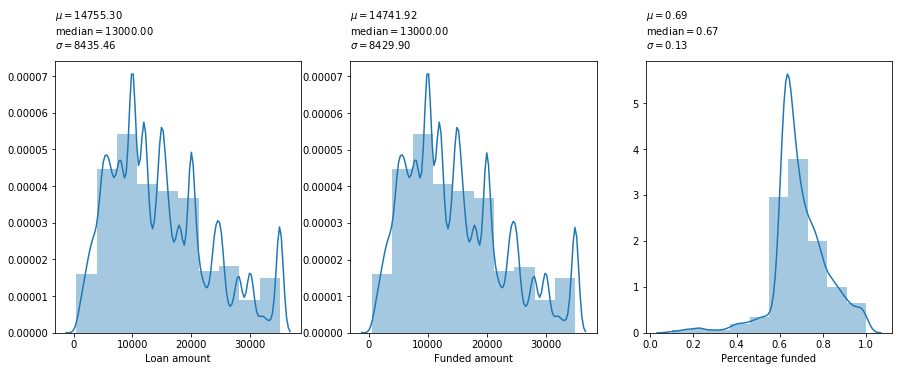

,Loan amount,Count
1,10000.0,61837.0
2,12000.0,50183.0
3,15000.0,47210.0
4,20000.0,46932.0
5,35000.0,36368.0


In [13]:
fig = plt.figure(figsize = (15, 5))

ax = fig.add_subplot(1, 3, 1)
x = df['loan_amnt']
plot(x, ax, 'Loan amount')

ax = fig.add_subplot(1, 3, 2)
x = df['funded_amnt']
plot(x, ax, 'Funded amount')

ax = fig.add_subplot(1, 3, 3)
x = df['funded_amnt']/df['loan_amnt']
x = x[x != 1]
plot(x, ax, 'Percentage funded')
#plt.savefig('loan_funding_amnts.png', bbox_inches='tight', dpi=480)

print('')
print("%.2f%% of loans are fully funded" % (100-len(x)/len(df)*100))
plt.show()

display(pd.DataFrame(data=[df['loan_amnt'].value_counts().head().index, df['loan_amnt'].value_counts().head()],
                     columns=range(1,6), index=['Loan amount', 'Count']).transpose())

Loan and funding amounts resemble slightly positively skewed Gaussian distributions. Spikes in the kernel density estimation are likely due to human-driven preferences for round numbers (see the above table with ranked loan amounts). Almost all loans are fully funded, but of the small number that are not fully funded, they receive 69% of their requested amount, on average.

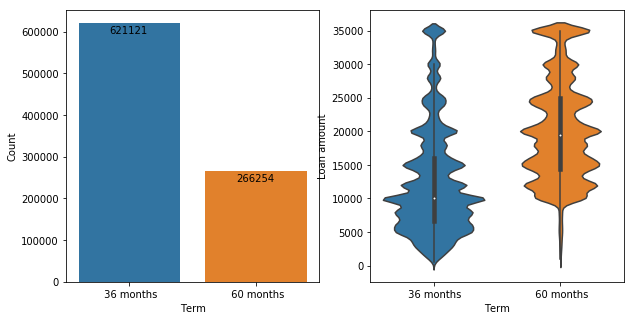

In [14]:
fig = plt.figure(figsize = (10, 5))

ax = fig.add_subplot(1, 2, 1)
sns.countplot(df['term'])
ax.set_xlabel('Term')
ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.24, p.get_height()-25000))

ax = fig.add_subplot(1, 2, 2)
sns.violinplot(x='term', y='loan_amnt', data=df)
ax.set_xlabel('Term')
ax.set_ylabel('Loan amount')

plt.show()

There are over twice as many 36-month loans than 72-month loans issues. The former skew more toward lower loan amounts, while the latter are more evenly distributed about the higher mean for 72-month loan amounts.

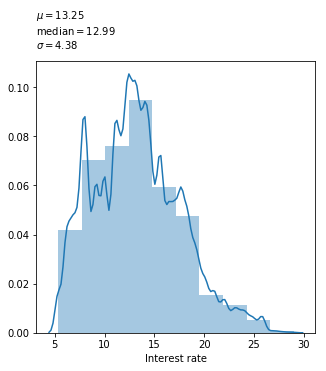

In [15]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
x = df['int_rate']
plot(x, ax, 'Interest rate')

Interest rates are positively skewed, with an average of 13.25%.

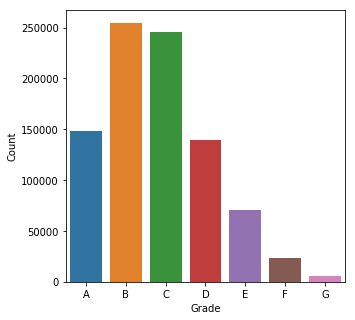

In [16]:
fig = plt.figure(figsize = (5, 5))
ax = sns.countplot(df['grade'])
ax.set_xlabel('Grade')
ax.set_ylabel('Count')
plt.show()

Most loans issued are rated "B" and "C" by Lending Club. The riskiest lendees are receiving relatively few loans on the platform, likely because there are fewer lenders willing to provide capital to that risk profile, or because the high interest rates given to lendees in this risk pool result in them not taking a loan in the first place.

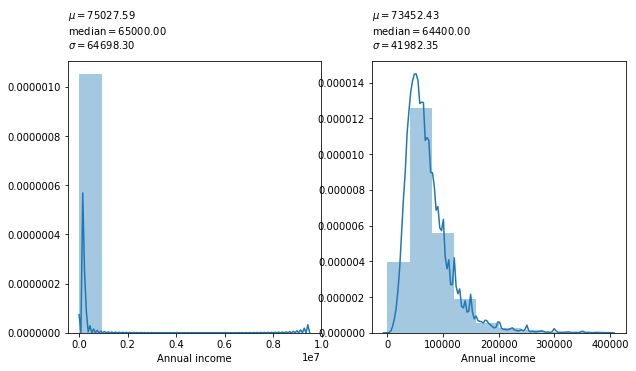

In [17]:
fig = plt.figure(figsize = (10, 5))

ax = fig.add_subplot(1, 2, 1)
x = df['annual_inc']
plot(x, ax, 'Annual income')

ax = fig.add_subplot(1, 2, 2)
x = x[x < 400000]
plot(x, ax, 'Annual income')

Annual income is highly positively skewed. On average, lendees make approximately \$75,000 per year, with a small number making up to just under \$1,000,000 annually. There is no need to remove any of the data at this point, but at a later point we will have to adjust the distribution of these data, if using a logistic regressor that requires normality.

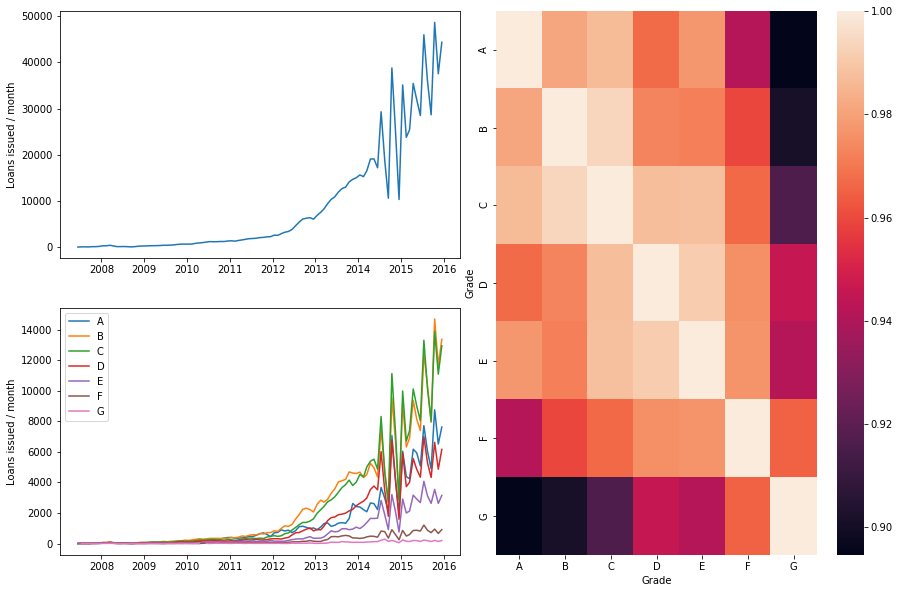

In [22]:
loans_all = df['issue_d'].value_counts(sort=False).sort_index()
loans_grd = df.groupby(['grade', 'issue_d']).size().unstack(level=0)

fig = plt.figure(figsize = (15, 10))
gs = gridspec.GridSpec(2, 4)

ax = fig.add_subplot(gs[0, 0:2])
plt.plot(loans_all)
plt.ylabel('Loans issued / month')

ax = fig.add_subplot(gs[1, 0:2])
plt.plot(loans_grd)
plt.ylabel('Loans issued / month')
plt.legend(loans_grd.columns)

ax = fig.add_subplot(gs[0:2, 2:4])
sns.heatmap(loans_grd.corr())
ax.set_xlabel('Grade')
ax.set_ylabel('Grade')
plt.show()

The number of loans issued each month has increased over time, sharply increasing from 2012 to the end of 2015. This trend is not as evident for lower grade (**`F`** and **`G`**) loans. Starting in mid-2014, an increase in temporal volatility is evident. This behavior appears across all loan classes (pairwise correlation > 0.9 for all classes).

It is possible these monthly spikes are due to business decisions that Lending Club, including advertising, that might have affected how many people gave money to the platform to lend, or how many people sought loans. We can investigate some of the other features to see if they are correlated with the number of loans issued per month. Let's look at average monthly funded amounts, interest rates, annual income of lendees, and the monthly payment for each loan.

In [36]:
# Calculate monthly payment for each loan
def calculate_monthly_payment(df):
    term_months = df['term'].apply(lambda x: int(x.split(' months')[0]))
    interest = df['int_rate'] / 100
    amount = df['funded_amnt']
    discount = (((1 + interest/12) ** term_months) - 1) / (interest/12 * (1 + interest/12) ** term_months)
    return amount / discount
    
df['monthly_payment'] = calculate_monthly_payment(df)

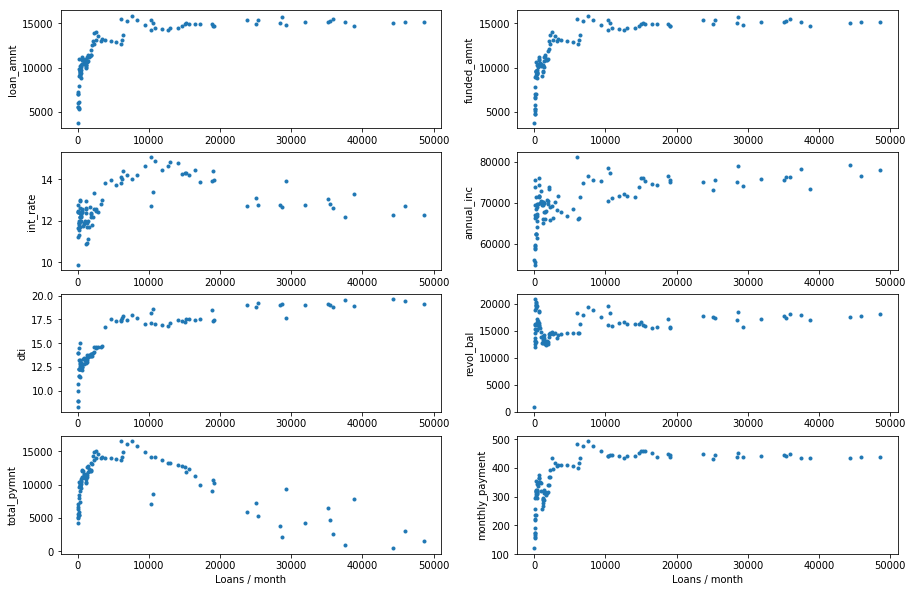

In [67]:
df_mean = df.groupby('issue_d').mean()
df_std = df.groupby('issue_d').std()
df_mean['loans_all'] = loans_all

fig = plt.figure(figsize = (15, 10))

for ii, c in enumerate(df_mean.columns):
    if c == 'loans_all':
        continue
    ax = fig.add_subplot(4, 2, ii+1)
    plt.plot(df_mean['loans_all'], df_mean[c], '.')
    ax.set_ylabel(c)
    if ii >= len(df_mean.columns) - 3:
        ax.set_xlabel('Loans / month')

No numeric variable is well correlated with the number of loans per month, especially at the higher loan volumes associated with increased temporal volatility. For now, we will simply have to attribute this behavior to something outside the scope of this dataset.

In [78]:
display(pd.DataFrame(data=[df['loan_status'].value_counts().index, df['loan_status'].value_counts()],
                     index=['Loan status', 'Count']).transpose())

,Loan status,Count
0,Current,601779
1,Fully Paid,207723
2,Charged Off,45248
3,Late (31-120 days),11591
4,Issued,8460
5,In Grace Period,6253
6,Late (16-30 days),2357
7,Does not meet the credit policy. Status:Fully ...,1984
8,Default,1219
9,Does not meet the credit policy. Status:Charge...,761


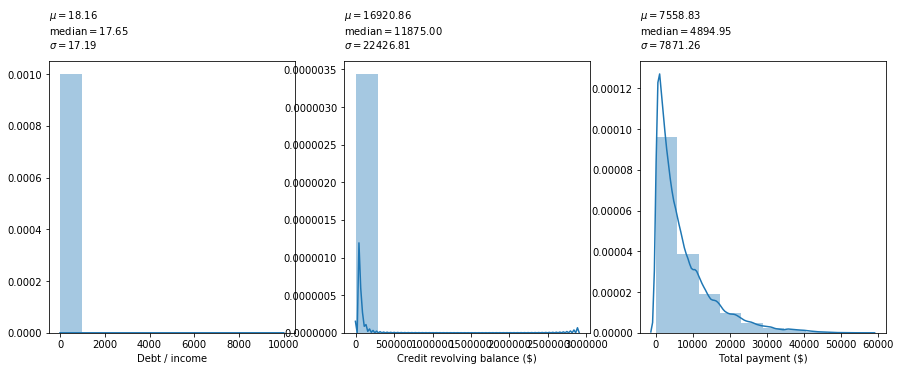

In [83]:
fig = plt.figure(figsize = (15, 5))

ax = fig.add_subplot(1, 3, 1)
x = df['dti']
plot(x, ax, 'Debt / income')

ax = fig.add_subplot(1, 3, 2)
x = df['revol_bal']
plot(x, ax, 'Credit revolving balance ($)')

ax = fig.add_subplot(1, 3, 3)
x = df['total_pymnt']
plot(x, ax, 'Total payment ($)')

Debt to income ratio is extremely skewed, for the same reasons that apply to annual income, and can be dealt with in the same way. Credit revolving balance and total payment are both highly skewed as well.

---
Let's try to get some insight into the variance of the system as a whole, and how that might relate to loan grades.

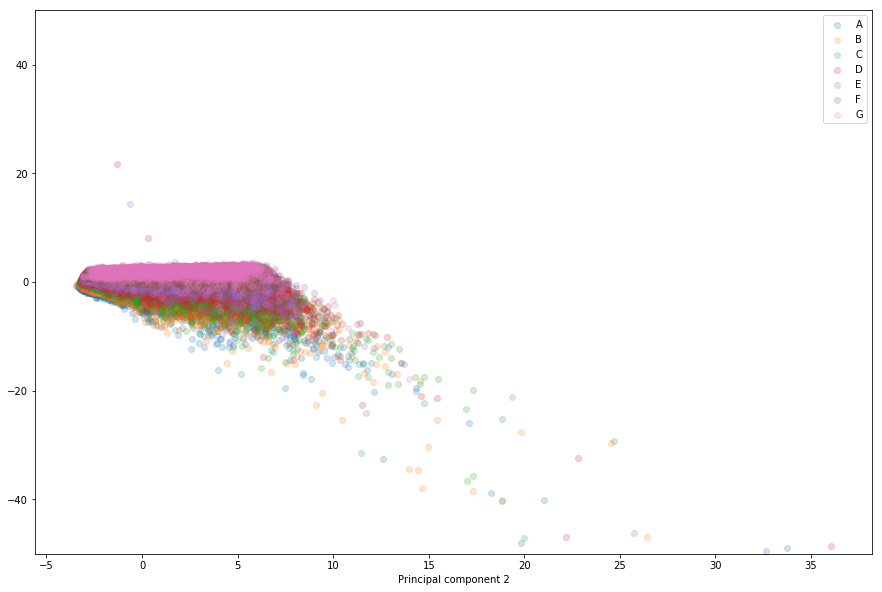

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
Percent explained variance,0.44667,0.150105,0.129502,0.100459,0.083535,0.080955,0.008682,0.000091


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
loan_amnt,0.509507,0.049335,-0.011757,0.168143,0.023091,-0.231568,-0.400309,0.703672
funded_amnt,0.509510,0.049481,-0.011205,0.168508,0.023496,-0.233592,-0.386703,-0.710474
int_rate,0.094979,0.665576,-0.073328,-0.711061,0.057874,-0.182752,0.015962,0.000289
annual_inc,0.240097,-0.509997,0.035759,-0.436940,0.679518,0.168276,-0.000338,-0.000200
dti,0.006876,0.335592,0.852729,0.194896,0.277121,0.213081,-0.000010,0.000192
revol_bal,0.237804,-0.366008,0.443738,-0.419003,-0.660085,0.034690,0.010197,-0.000113
total_pymnt,0.322427,0.206272,-0.260475,0.025745,-0.144795,0.871885,-0.061890,-0.001958
monthly_payment,0.503564,0.053833,-0.034402,0.180548,0.018603,-0.152663,0.828266,0.008232


In [190]:
# Pull out numeric features and standardize them
col_numeric = [c for c in df.columns if str(df.dtypes[c]) == 'float64']
x = df.loc[:, col_numeric].values
x = StandardScaler().fit_transform(x)

# Pull out grades
y = df.loc[:, ['grade']].values

# Perform principal component analysis on numeric features
n_components = 8
pca = PCA(n_components=n_components)
projection = pca.fit_transform(x)
df_pca = pd.DataFrame(data=projection, columns=['PC_' + str(ii) for ii in range(1, n_components+1)])
df_pca['grade'] = y

# Plot first two principal components
fig = plt.figure(figsize = (15, 10))
for c in loans_grd.columns.tolist():
    I = df_pca['grade'] == c
    plt.scatter(x=df_pca.loc[I, 'PC_1'], y=df_pca.loc[I, 'PC_2'], alpha=0.2)
plt.xlabel('Principal component 1')
plt.xlabel('Principal component 2')
plt.ylim([-50, 50])
plt.legend(loans_grd.columns)
plt.savefig('loan_grades_pca.png', dpi=480)
plt.show()

display(pd.DataFrame(data=pca.explained_variance_ratio_, columns=['Percent explained variance'],
                     index=['PC_' + str(ii) for ii in range(1, n_components+1)]).transpose())
display(pd.DataFrame(data=pca.components_, columns=col_numeric,
                     index=['PC_' + str(ii) for ii in range(1, n_components+1)]).transpose())

The first three principal components of the system's numeric features explain over 70% of the variance in the system.

The first principal component exhibits power associated with the following: **`loan_amnt`**, **`funded_amnt`**, and **`monthly_payment`** (derived variable).

The second principal component exhibits power associated with the following: **`int_rate`**, and **`annual_inc`**

The third principal component exhibits power associated with the following: **`dti`** and **`revol_bal`**

Using this it is possible to look for groupings between loan grade classes. For example, at higher values of principal component 1, separation between loan grades is visible as a function of principal component 2.

---
From here, let's examine how loan risk has changed across loan grades through Lending Club's history.

We can combine the calculated monthly payments for the new loan with the lendee's reported income to derive a Lending Club-specific debt to income ratio.

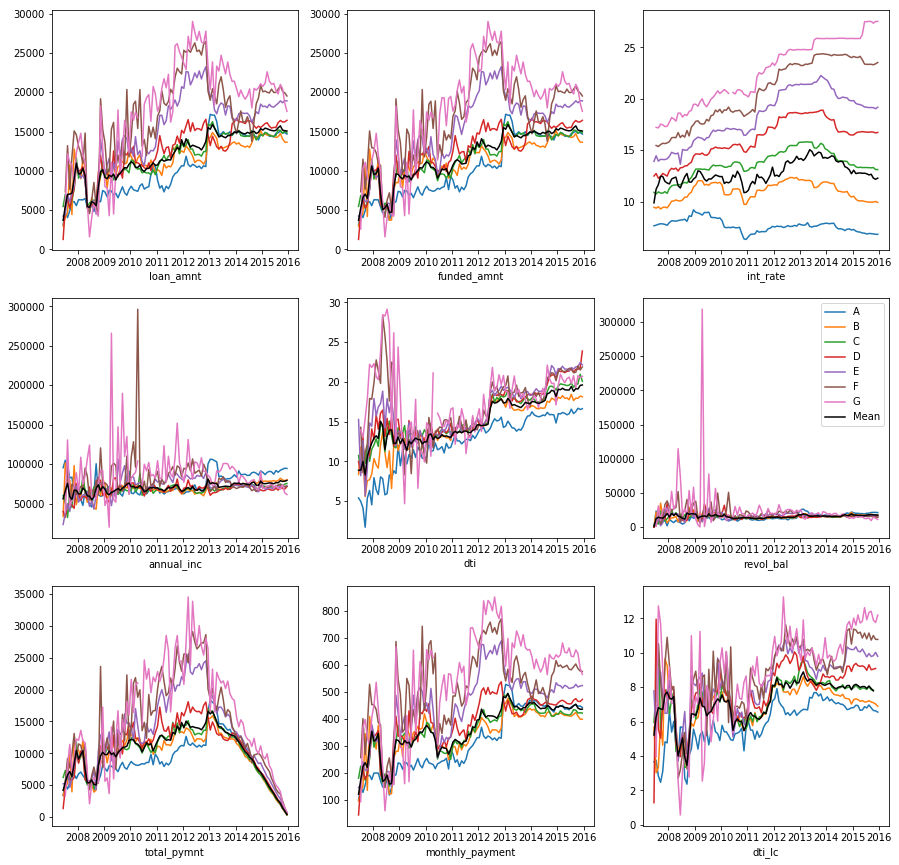

In [265]:
df['dti_lc'] = df['monthly_payment'] / (df['annual_inc'] / 12) * 100
loans_monthly_all = df.groupby(['grade', 'issue_d']).mean()
loans_monthly = df.groupby('issue_d').mean()

grades = [g for g in loans_grd.columns]
leg = [g for g in grades]
leg.append('Mean')
fig = plt.figure(figsize = (15, 15))
x = [t for t in range(0, len(loans_monthly.index))]
for ii, c in enumerate(loans_monthly_all.columns):
    ax = fig.add_subplot(3, 3, ii+1)
    for g in grades:
        plt.plot(loans_monthly_all.loc[g].index, loans_monthly_all.loc[g, c])
        ax.set_xlabel(c)
    plt.plot(loans_monthly.index, loans_monthly.loc[:, c], 'k')
    reg = LinearRegression
    if ii == 5:
        plt.legend(leg)
plt.savefig('loan_trends_temporal.png', dpi=480)
plt.show()

Over time, it is clear that Lending Club has been issuing larger loans, with higher interest rates. Rising interest rates are primarily limited to the riskiest tranches of loan grades. "A" grade loans have actually seen a decrease in average interest rate since 2007. Across the board, Lending Club customers are increasingly burdened with debt _before_ they take out a loand from Lending Club. Ignoring the spikes in low grade loan debt to income ratios in 2008-2010, debt to income ratio is increasing across all loan grades.

###  Part 2: Business Analysis
---
Here, we evaluate the investment potential of 36-month loans.

---
1) What percentage of loans has been fully paid?

We have to select the following from our dataset:
- 36-month term loans
- Loans that are still being repaid (current)
- Loans with less than 36 months of data

In [367]:
I = (df['term'] == '36 months') | (df['loan_status'] != 'Current') 
df_36 = df.loc[I, :]

Find the date 36 months _before_ the last date in the dataset, and remove loans that were issued after that.

In [368]:
t_max = df['issue_d'].max()
t_start = pd.datetime(t_max.year-3, t_max.month, t_max.day)
I = df_36['issue_d'] < t_start
df_36 = df_36.loc[I, :]

Now we can calculate the percentage of loans that have been fully paid.

In [369]:
I = (df_36['loan_status'] == 'Fully Paid') | \
    (df_36['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid')
print("%.2f%% of loans have been fully paid." % float(len(df_36.loc[I, :])*100 / len(df_36)))

83.54% of loans have been fully paid.


2) When bucketed by year of origination and grade, which cohort has the highest rate of defaults?

In [430]:
df_36['issue_year'] = df_36['issue_d'].apply(lambda x: x.year)
I = df_36['loan_status'] != 'Fully Paid'
df_36['default'] = I.astype(int)
df_36_defaults = df_36.groupby(['issue_year', 'grade'])['default'].agg('sum') / \
    df_36.groupby(['issue_year', 'grade'])['default'].agg('count')
display(pd.DataFrame(df_36_defaults[df_36_defaults == df_36_defaults.max()]))

,,default
issue_year,grade,
2007,G,1.0


2007 "G" grade loans had a default rate of 100%

3) When bucketed by year of origination and grade, what annualized rate of return have these loans generated on
average?

We need to include both fully paid loans, as well as those in default, as the annualized rate of return needs to account for the entire suite of loans - those that make money, as well as those that lose money.

In [461]:
df_36['arr'] = (df_36['total_pymnt'] / df_36['funded_amnt']) ** (1/3) - 1
display(pd.DataFrame(df_36.groupby(['issue_year', 'grade'])['arr'].agg('mean').unstack('grade')))
print('Overall average annualized rate of return: {}'.format(df_36.groupby(['issue_year',
                                                                            'grade'])['arr'].agg('mean').mean()))

grade,A,B,C,D,E,F,G
issue_year,,,,,,,
2007,0.026436,-0.001888,-0.008031,-0.014353,-0.015099,-0.079863,-0.044102
2008,0.023445,-0.000428,-0.004508,-0.018365,-0.003337,-0.045138,-0.007913
2009,0.021337,0.014358,0.011975,0.013982,-0.000270,0.002615,0.002985
2010,0.022177,0.022048,0.022898,0.016750,0.023607,0.024565,0.020042
2011,0.014944,0.017562,0.007936,0.005552,-0.000917,-0.011654,-0.018332
2012,0.014939,0.020380,0.016924,0.010668,-0.010763,-0.016310,-0.038422


Overall average annualized rate of return: 0.0009150568548158219


###  Part 3: Modeling


,A,B,C,D,E,F,G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0
6,0,0,1,0,0,0,0
7,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0
9,0,1,0,0,0,0,0
